**Содержание**<a id='toc0_'></a>    
- [Установка NebulaGraph](#toc1_)    
- [Считывание данных из источника](#toc2_)    
- [Внесение данных из таблицы в графовую БД](#toc3_)    
- [Графовое представление в БД](#toc4_)    
  - [Ориентированный граф](#toc4_1_)    
    - [Степени вершин](#toc4_1_1_)    
    - [Множества достижимости и контрдостижимости вершин](#toc4_1_2_)    
    - [Циклы и компоненты сильной связности](#toc4_1_3_)    
  - [Неориентированный граф](#toc4_2_)    
    - [Степени вершин](#toc4_2_1_)    
    - [Циклы и компоненты связности](#toc4_2_2_)    
  - [Визуализация](#toc4_3_)    
  - [Выводы](#toc4_4_)    
- [REST сервис](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Установка NebulaGraph](#toc0_)

Можно установить Docker Desktop и выбрать мышкой, или взять docker контейнеры из репозитория:
```
git clone -b release-3.4 https://github.com/vesoft-inc/nebula-docker-compose.git
cd ./nebula-docker-compose
docker compose up -d
```
Состоит из трех кластеризованных сервисов (meta, graph, storage) + консоль.

Подключение к контейнеру с консолью СУБД: `docker exec -it nebula-docker-compose-console-1 /bin/sh`

Открыть консоль СУБД в контейнере: `nebula-console -u root --address=graphd --port=9669`
- `root` дефолтный пользователь без пароля
    - `SHOW USERS;`
    - `CHANGE PASSWORD <user_name> FROM '<old_password>' TO '<new_password>';`

Выключить: `docker compose down`

In [1]:
# !cd ~/development/nebula-docker-compose && docker compose up -d
# !cd ~/development/nebula-docker-compose && docker compose down

# <a id='toc2_'></a>[Считывание данных из источника](#toc0_)

In [2]:
import pandas as pd

DATA = "./GraphData/data_test.csv"

df = pd.read_csv(DATA, header=0, names=["eid", "name1", "name2"], sep=";")

unique = pd.concat((df.name1, df.name2), axis=0).unique()
intersect = set(df.name1).intersection(set(df.name2))

df.shape[0], unique.shape[0], len(intersect), max(map(len, unique))

(5000, 9899, 25, 37)

- всего записей в датасете 5000, 
- поля `name1` и `name2` содержат 9899 уникальных объекта, 
- пересечение множеств уникальных значений полей `name1` и `name2` содержит 25 объектов
- максимальная длина идентификатора объекта 37 символов

Сразу добавим идентификаторы/индексы вершин

In [3]:
vids = pd.DataFrame({"name": unique}).reset_index()

df["vid1"] = pd.merge(df.name1, vids, how="left", left_on="name1", right_on="name")["index"]
df["vid2"] = pd.merge(df.name2, vids, how="left", left_on="name2", right_on="name")["index"]

df[["eid",	"vid1",	"vid2", "name1", "name2"]].head()

,eid,vid1,vid2,name1,name2
0,189,0,4930,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,1,4931,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,2,4932,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,3,4933,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,4,4934,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна


# <a id='toc3_'></a>[Внесение данных из таблицы в графовую БД](#toc0_)

In [4]:
# адрес и порт graphd сервиса
HOST = "127.0.0.1"      
PORT = 9669

USER = "root"
PASS = ""

SPACE = "relations"   # назовем схему данных так

Официальные биндинги к API СУБД из питона - пакет `nebula3-python` (версия должна соответствовать СУБД). Есть два вида соединения для выполнения запросов к БД:
- отдельная сессия - для существующего пользователя и конкретного пространства (аналог схемы в SQL), в т.ч. служит для разграничения прав доступа
- пул соединений - можно создавать пространства, пользователей и т.п.

In [5]:
# !pip install nebula3-python==3.4
import time

from tqdm import tqdm

from nebula3.Config import Config
from nebula3.gclient.net import ConnectionPool

config = Config()
config.max_connection_pool_size = 10

# init connection pool
connection_pool = ConnectionPool()
# the graphd server's address
assert connection_pool.init([(HOST, PORT)], config)

- создание схемы БД
- внесение данных

In [6]:
def is_space(conn, space):
    with conn.session_context(USER, PASS) as session:
        res = session.execute("SHOW SPACES;")       # ResultSet
        res = res.column_values("Name")             # list of ValueWrapper
        res = [val.as_string() for val in res]
    return space in set(res)

def init_db(conn, space, nodes=vids, edges=df, drop=False, sleep=10):
    """Чтоб не ждать бесконечных слипов, пересоздание схемы только:
        - если прямо сказано drop=True, или 
        - если схемы с именем space еще нет
    """
    nGQL_drop   = f"DROP SPACE IF EXISTS {space};"
    nGQL_create = f"CREATE SPACE IF NOT EXISTS {space}("    \
                   "PARTITION_NUM=5,"                       \
                   "REPLICA_FACTOR=1,"                      \
                   "vid_type=FIXED_STRING(30));"
    nGQL_tags   = f"USE {space};"                                   \
                   "CREATE TAG IF NOT EXISTS person(name string);"  \
                   "CREATE EDGE IF NOT EXISTS r();"
    
    # для экспериментов, хотя совет из манула: DO NOT USE index
    # - индекс до 10 раз может замедлить вставку, но ускоряются LOOKUP и GO, 
    # а в MATCH снимаются ограничения на синтаксис
    nGQL_index  = f"CREATE TAG INDEX IF NOT EXISTS pers_index on person();"  \
                   "CREATE EDGE INDEX IF NOT EXISTS r_index on r();"         

    with conn.session_context(USER, PASS) as session:
        if drop:
            session.execute(nGQL_drop)

        if drop or not is_space(conn, space):   # слипы из официального мануала - по 20 сек.
            print(f"Building space '{space}'")
            session.execute(nGQL_create)
            time.sleep(sleep)                   # без этого слипа на тесте все работает
            session.execute(nGQL_tags)
            time.sleep(sleep)                   # без этого слипа на тесте все работает
            session.execute(nGQL_index)
            time.sleep(sleep)                   # без этого слипа СУБД потеряет часть данных при добавлении :P
        else:
            print(f"Space '{space}' allready up-to-date\n(pass 'drop=True' to force rebuild)")

    if drop:
        with conn.session_context(USER, PASS) as session:
            session.execute(f"USE {space};")

            for _, row in tqdm(nodes.iterrows(), total=nodes.shape[0], desc='Vertexes'):
                vid = f"{row['index']}"
                cmd = f"INSERT VERTEX person(name) VALUES \"{vid}\":(\"{row['name']}\")"
                session.execute(cmd)

            for _, row in tqdm(edges.iterrows(), total=edges.shape[0], desc='Edges'):
                vid1 = f"{row['vid1']}"
                vid2 = f"{row['vid2']}"
                cmd = f"INSERT EDGE r() VALUES \"{vid1}\"->\"{vid2}\":()"
                session.execute(cmd)

init_db(connection_pool, SPACE)

Space 'relations' allready up-to-date
(pass 'drop=True' to force rebuild)


Производительность:
- ~600 запросов в сек. при добавлении данных
- ~1200 запросов в сек. при отклонении ошибочных запросов

Комментарий:
- в БД данные вводятся как ориентированные в направлении от `name1` к `name2`

# <a id='toc4_'></a>[Графовое представление в БД](#toc0_)

Язык запросов NebulaGraph называется `nGQL` и включает в себя подмножество языка `openCypher`. Нельзя смешивать в одном запросе два диалекта:
- openCypher (MATCH, RETURN, WITH ...)
- native nGQL (FETCH, GO, LOOKUP ...)

В native nGQL есть интересный синтаксис подзапросов в виде unix-like пайплайнов через `|` (синхронный, аналог `WITH`).

In [7]:
from typing import Dict

def result_to_df(result): 
    """
    build list for each column, and transform to dataframe 
    (рекомендуемый способ из мануала)
    """
    assert result.is_succeeded(), "Похоже, ошибка в запросе nGQL"
    columns = result.keys()
    d: Dict[str, list] = {}
    for col_num in range(result.col_size()):
        col_name = columns[col_num]
        col_list = result.column_values(col_name)
        d[col_name] = [x.cast() for x in col_list]
    return pd.DataFrame.from_dict(d)

def q(query, conn=connection_pool):
    """Запрос к БД на языке NGQL"""
    with conn.session_context(USER, PASS) as session:
        session.execute(f"USE {SPACE};")
        result = session.execute(query)

    return result_to_df(result)

In [8]:
#native nGQL: "LOOKUP ON person YIELD id(vertex) | YIELD COUNT(*) AS Total;"
v_num = "MATCH (v:person) RETURN count(v.person.name) AS v_num;"
e_num = "MATCH ()-[r]->() RETURN count(r) AS e_num;"

pd.concat((q(v_num).T, q(e_num).T))

,0
v_num,9899
e_num,5000


Все вводимые данные в БД сохранились

## <a id='toc4_1_'></a>[Ориентированный граф](#toc0_)

### <a id='toc4_1_1_'></a>[Степени вершин](#toc0_)

Вершины по количеству входящих и исходящих связей
- при `length="1"` соответсвует понятию степени вершины (точнее полустепени захода/исхода, но будем называть их степенями)

In [9]:
def dst(vid, length="1"):
    """Вершины в которые из vid есть путь длины length"""
    return f"MATCH (v1)-[e:r*{length}]->(v2) WHERE id(v1) == '{vid}' RETURN id(v2) AS vid, v2.person.name AS name;"

def dst_count(length="1"):
    """Количество вершин, в которые есть путь длины length из vid"""
    return f"MATCH (v1:person)-[r*{length}]->(v2:person) RETURN id(v1) AS vid, v1.person.name AS name, COUNT(DISTINCT id(v2)) AS Ndst ORDER BY Ndst DESC;"

def src(vid, length="1"):
    """Вершины из которых в vid есть путь длины length"""
    return f"MATCH (v1)<-[e:r*{length}]-(v2) WHERE id(v1) == '{vid}' RETURN id(v2) AS vid, v2.person.name AS name;"

def src_count(length="1"):
    """Количество вершин, из которых есть путь длины length в vid"""
    return f"MATCH (v1:person)<-[r*{length}]-(v2:person) RETURN id(v1) AS vid, v1.person.name AS name, COUNT(DISTINCT id(v2)) AS Nsrc ORDER BY Nsrc DESC;"

q(dst_count()).head()

,vid,name,Ndst
0,221,Ахромеева Алина Ивановна,49
1,341,Башнина Антонина Глебовна,14
2,1794,Диомидов Игорь Ильдарович,5
3,661,Зимнухова Карина Даниловна,4
4,503,Пафомова Кира Вадимовна,2


In [10]:
q(src_count()).head()

,vid,name,Nsrc
0,873,Медведева Дарья Алексеевна,5
1,1766,Двигубская Валентина Геннадьевна,2
2,1098,Шолохов Игорь Робертович,2
3,9836,Ермилова Екатерина Федоровна,1
4,9147,Шулятикова Анастасия Михаиловна,1


- Максимальная исходящая степень вершины $d^-(v_{221}) = 49$, 
- Максимальная входящая степень вершины $d^+(v_{873}) = 5$

### <a id='toc4_1_2_'></a>[Множества достижимости и контрдостижимости вершин](#toc0_)

- при `length="1.."` соответсвует понятию достижимости (`dst_count` - какие вершины могут быть достигнуты из данной) и контрдостижимости вершин (`src_count` - из каких вершин может быть достигнута данная)

In [11]:
dst_power = q(dst_count("1.."))
dst_power.head()

,vid,name,Ndst
0,3968,Ошуров Павел Ильдарович,50
1,221,Ахромеева Алина Ивановна,49
2,341,Башнина Антонина Глебовна,14
3,4505,Ляуданский Валентин Владиславович,13
4,3611,Троекуров Глеб Ефимович,13


In [12]:
src_power = q(src_count("1.."))
src_power.head()

,vid,name,Nsrc
0,1455,Даниленко Владимир Семенович,13
1,1766,Двигубская Валентина Геннадьевна,13
2,1926,Ивашев Вячеслав Игоревич,13
3,3959,Дорожкин Анатолий Егорович,13
4,4503,Рыскина Эльмира Ивановна,13


- квантили степеней вершин

In [13]:
dst_power.Ndst.quantile(0.99), src_power.Nsrc.quantile(0.99)

(1.0, 2.0)

- 99% квантиль мощности множества достижимости для вершин графа равен 1.0 вершине
- 99% квантиль мощности множества контрдостижимости для вершин графа равен 2.0 вершинам (98% квантиль - 1 вершина)

Из этого можно сделать вывод, что все вершины в представленном графе, которые связаны более чем с 1 вершиной, можно считать выбросами с точки зрения статистики.

### <a id='toc4_1_3_'></a>[Циклы и компоненты сильной связности](#toc0_)

В ориентированном графе циклы являются частным случаем компонент сильной связности. В общем случае компонента сильной связности ор.графа может состоять из нескольких циклов, имеющих общие вершины.

Количество циклов `cycle_count`:
- `length="0"` количество вершин в графе
- `length="1"` количество петель в графе (**отсутствуют**)
- `length="2"` количество вершин, связанных условно неориентированным ребром (**отсутствуют**)
- `length="3"` количество циклов длины 3 (**отсутствуют**)
- ...

In [14]:
def cycle_count(length="1"):
    """Вершины, которые входят в цикл длины length"""
    return f"MATCH p = (v)-[r*{length}]->(v) RETURN id(v) AS vid, v.person.name AS name, length(p) AS length, r AS cycle ORDER BY length DESC"

def path_to_idx(path):
    return "->".join([e.start_vertex_id().as_string() for e in path])

cycles = q(cycle_count("2.."))
cycles['cycle'] = cycles.cycle.apply(path_to_idx)
cycles

,vid,name,length,cycle
0,3710,Торгунаков Роман Кириллович,7,3710->1098->2042->3611->4727->503->4505
1,503,Пафомова Кира Вадимовна,7,503->4505->3710->1098->2042->3611->4727
2,4505,Ляуданский Валентин Владиславович,7,4505->3710->1098->2042->3611->4727->503
3,3611,Троекуров Глеб Ефимович,7,3611->4727->503->4505->3710->1098->2042
4,4727,Мараховская Дарья Романовна,7,4727->503->4505->3710->1098->2042->3611
5,2042,Нагайцева Анжелика Яновна,7,2042->3611->4727->503->4505->3710->1098
6,1098,Шолохов Игорь Робертович,7,1098->2042->3611->4727->503->4505->3710
7,3279,Батиевская Ангелина Романовна,6,3279->3959->1766->1926->4503->1455
8,4053,Поскребышев Яков Дмитриевич,6,4053->1627->3679->3366->975->3966
9,1455,Даниленко Владимир Семенович,6,1455->3279->3959->1766->1926->4503


В графе есть циклы: один $C_5$, два $C_6$ и один $C_7$. Все вершины цикла длины 5 принадлежат множеству вершин цикла длины 7.

## <a id='toc4_2_'></a>[Неориентированный граф](#toc0_)
### <a id='toc4_2_1_'></a>[Степени вершин](#toc0_)

Смежные вершины получаются при `length="1"`, при других значениях - множества достижимости с максимальной длиной пути `length`.

In [15]:
def deg(vid, length="1"):
    """Вершины, которые принадлежат пути длины length"""
    return f"MATCH (v1)-[e:r*{length}]-(v2) WHERE id(v1) == '{vid}' RETURN id(v2) AS vid, v2.person.name AS name;"

def deg_count(length="1"):
    """Количество вершин, которое достижимо из данной вершины"""
    return f"MATCH (v1:person)-[r*{length}]-(v2:person) RETURN id(v1) as vid, v1.person.name AS name, COUNT(*) as deg ORDER BY deg DESC;"

degs = q(deg_count("1"))
degs.head()

,vid,name,deg
0,221,Ахромеева Алина Ивановна,50
1,341,Башнина Антонина Глебовна,14
2,873,Медведева Дарья Алексеевна,6
3,1794,Диомидов Игорь Ильдарович,5
4,661,Зимнухова Карина Даниловна,5


In [16]:
degs[degs['deg'] > 1].shape[0]

27

### <a id='toc4_2_2_'></a>[Циклы и компоненты связности](#toc0_)

In [17]:
def cycle1_count(length="1"):
    """Вершины, которые входят в цикл длины length"""
    return f"MATCH p = (v)-[r*{length}]-(v) RETURN id(v) AS vid, v.person.name AS name, length(p) AS length, r AS relations ORDER BY length DESC;"

def path1_to_vid(vid, path, to_set=False):
    """Путь из произвольно ориентированных ребер в последовательность вершин
    - если хотим группировать по множеству вершин цикла, то через frozenset хешируемый тип"""

    result = [None] * len(path)
    result[0], prev = vid, vid

    for i in range(len(path)):
        if prev == path[i].start_vertex_id().as_string():
            nxt = path[i].end_vertex_id().as_string()
        else:
            nxt = path[i].start_vertex_id().as_string()
        if i > 0: result[i] = prev
        prev = nxt
    return frozenset(result) if to_set else "-".join(result)


cycles1 = q(cycle1_count("1.."))
cycles1['cycle'] = cycles1.apply(lambda x: path1_to_vid(x.vid, x.relations), axis=1)
cycles1['nodes'] = cycles1.apply(lambda x: path1_to_vid(x.vid, x.relations, to_set=True), axis=1)


# добавим в датафрейм степень вершины, может пригодиться
cycle_degs = pd.merge(cycles1.vid, degs, on='vid', how="left")   
cycles1["deg"] = cycle_degs["deg"]

cycles1[["vid", "name", "deg", "length", "cycle", "nodes"]]

cycles1['deg'].mean()

2.357142857142857

Степени вершин, входящих в циклы, не превышают 4 и в целом большинство их них имеют степень 2, т.е. они не имеют связи с другими вершинами графа

In [18]:
cycles1.groupby(by = "nodes").first()[["cycle", "length"]]

,cycle,length
nodes,,
"(3710, 4727, 503, 1098, 2042, 3611, 4505)",3611-4727-503-4505-3710-1098-2042,7
"(3366, 3679, 4053, 975, 1627, 3966)",3366-975-3966-4053-1627-3679,6
"(3959, 1766, 3279, 4503, 1926, 1455)",4503-1455-3279-3959-1766-1926,6
"(4727, 503, 2042, 1098, 3611)",3611-4727-503-1098-2042,5
"(503, 1098, 4505, 3710)",4505-503-1098-3710,4


В неор.графе есть циклы длины 4, 5, 6, 7. Есть циклы нечетной длины => граф не является двудольным (нельзя разделить множество вершин графа на два подмножества, внутри которых все вершины попарно несвязаны).

К циклам ор.графа, которые по множеству вершин должны входить в циклы неор.графа, добавился неор.цикл длины 4
- это возможно только в случае, когда в ор.графе есть 2 соединенные ребром вершины не входящие в цикл длины 5, и связанные с двумя соединенными ребром вершинами цикла длины 5
    - это вершины 3710 и 4505

In [19]:
def cc(vid):
    """Вершины, принадлежащие одной компоненте связаности с vid"""
    return f"MATCH p = (v)-[r*1..]-() WHERE id(v) == '{vid}' WITH v, nodes(p) AS n UNWIND n AS n1 RETURN id(v) AS vid, collect(DISTINCT n1) AS connected;"

def cс_count():
    """Мощности компоненты связности, которой принадлежит данная вершина"""
    return f"MATCH p = (v)-[r*1..]-() WITH v, nodes(p) AS n UNWIND n AS n1 RETURN DISTINCT id(v) AS vid, COUNT(DISTINCT n1) AS cc_power ORDER BY cc_power DESC;"

cc_powers = q(cс_count())

cc_powers[cc_powers.cc_power > 2]

,vid,cc_power
0,7008,51
1,5205,51
2,7872,51
3,5151,51
4,7064,51
...,...,...
100,3366,6
101,3679,6
102,3966,6
103,4053,6


In [20]:
cc_powers.cc_power.unique()

array([51, 15, 13,  7,  6,  2])

Кроме тривиальных компонент связности из 2 вершин граф включает к.с. из 51, 15, 13, 7,  6 вершин.

## <a id='toc4_3_'></a>[Визуализация](#toc0_)

Основные варианты визуализации графовых данных:

- python + graphviz
- NebulaGraph Explorer (платная лицензия или триал)
- сторонние инструменты визуализации Gephi и т.п.

Нам больше по душе python + graphviz

In [21]:
from graphviz import Digraph

compact_nodes = {'shape':'circle', 'fixedsize':'true','fontsize':"6", 'width':'0.25', 
                 'height':'0.25', 'color': 'lightgreen', 'style': 'filled'}

def draw(nodes, edges, red_nodes=(),
         engine='dot', # ['circo', 'dot', 'fdp', 'neato', 'osage', 'patchwork', 'sfdp', 'twopi']
         node_attr=compact_nodes, 
         edge_attr={'fontsize':"10", 'arrowsize':'0.5', 'penwidth':'0.3'},
        ): 
    """Рисует граф заданный nodes, edges"""
    dot = Digraph(engine=engine, node_attr=node_attr, edge_attr=edge_attr)
    [dot.node(node, color='red') if node in red_nodes else dot.node(node) for node in nodes]
    [dot.edge(*edge, color='red') if edge[0] in red_nodes else dot.edge(*edge) for edge in edges]

    return dot

- ребра, соединяющие вершины, из которых хотя бы одна не является листом

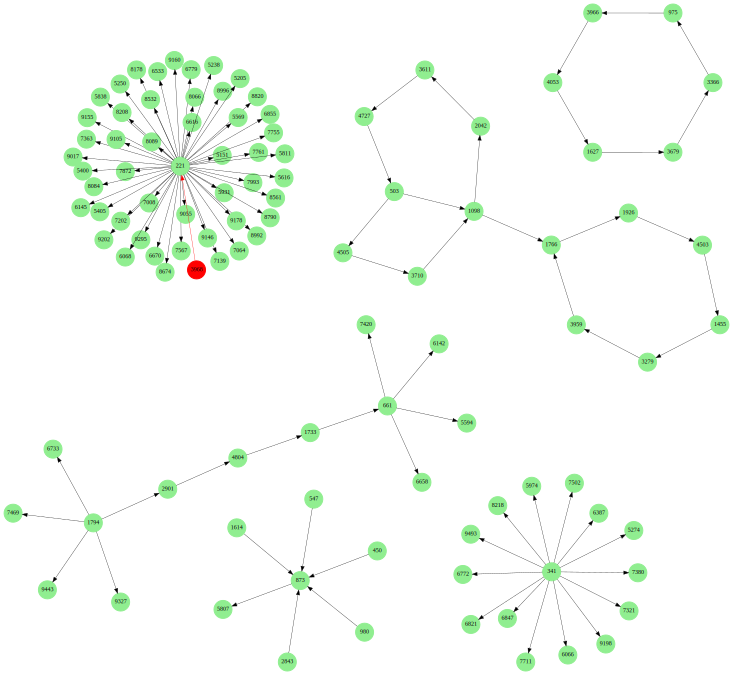

In [22]:
q1 = q("MATCH ()-[e]-()--() RETURN DISTINCT e;")

q1["v1"] = q1.e.apply(lambda x: x.start_vertex_id().as_string())
q1["v2"] = q1.e.apply(lambda x: x.end_vertex_id().as_string())
q1["edges"] = q1.apply(lambda x: (x.v1, x.v2), axis=1)

nodes = set(q1.v1).union(set(q1.v2))
edges = q1.edges

draw(nodes, edges, red_nodes=['3968'], engine='neato')    # можно подкрасить некоторые вершины

## <a id='toc4_4_'></a>[Выводы](#toc0_)

1. Графовые СУБД - это сила!
3. В ориентированном графе есть циклы: один $C_5$, два $C_6$ и один $C_7$. Все вершины $C_5$ принадлежат также множеству вершин $C_7$.
4. В аналогичном неориентированном графе к этим циклам добавляется еще один цикл $C_4$.
2. В представленном графе компоненты связности из более чем 2 вершин можно считать выбросами с точки зрения статистики.
5. Таких компонент связности с более чем 2 вершинами в графе насчитывается 6 штук.
6. Кроме тривиальных для данного графа компонент связности из 2 вершин, граф включает к.с. из 51, 15, 13, 7 и 6 вершин.
7. Визуализация компонент связности графа подтвеждает выводы, полученные алгоритмически. 



# <a id='toc5_'></a>[REST сервис](#toc0_)

REST сервис на python к графовой БД в котором на вход поступает ФИО, на выходе json

In [23]:
def rest(query, conn=connection_pool):
    """Запрос к БД на языке NGQL"""

    with conn.session_context(USER, PASS) as session:
        session.execute(f"USE {SPACE};")
        result = session.execute(query)
        if not result.is_succeeded():
            return []
    
    names = []
    if result.column_values("connected"):
        for node in [x.cast() for x in result.column_values("connected")][0]:
            names.append(node.prop_values("person")[0].cast())
        names = names[1:] # исключить саму вершину

    return names

def neighbours(name):
    """Вершины, смежные для name"""

    return f"MATCH p = (v)-[r*1]->() WHERE v.person.name == '{name}' WITH v, nodes(p) AS n UNWIND n AS n1 RETURN id(v) AS vid, collect(DISTINCT n1) AS connected;"

def reachable(name):
    """Вершины, достижимые из name"""
    
    return f"MATCH p = (v)-[r*1..]->() WHERE v.person.name == '{name}' WITH v, nodes(p) AS n UNWIND n AS n1 RETURN id(v) AS vid, collect(DISTINCT n1) AS connected;"

(
    len(rest(neighbours('Пафомова Кира Вадимовна'))),    # 2
    len(rest(reachable('Пафомова Кира Вадимовна'))),     # 12

    len(rest(neighbours('Ахромеева Алина Ивановна'))),   # 49
    len(rest(reachable('Ахромеева Алина Ивановна'))),    # 49

    len(rest(neighbours('Сапожник Борис Валерьевич'))),  # 0
    len(rest(reachable('Сапожник Борис Валерьевич'))),   # 0

    len(rest(neighbours('Нет Такого Персонажа'))),       # 0
)

(2, 12, 49, 49, 0, 0, 0)

```
$ pip install "uvicorn[standard]"
$ cd ./app
$ echo "DATABASE_USER=***" > ./.env
$ echo "DATABASE_PASS=***" >> ./.env
$ uvicorn main:app --reload
...
```

http://127.0.0.1:8000/docs